## Read raw data and generate timestamped graphs

In [2]:
from utils import *

data_dirname = "/coc/flash5/mpatel377/repos/SLaTe-PRO/data/RoboCraft/rawAnnotated"

list_of_datafiles = json.load(open(os.path.join(data_dirname, "../phase1_train_data.json")))

VERBOSE = False
NO_SUPPLYSHELF = True

shutil.rmtree("processed_seqLM_coarse", ignore_errors=True)
os.makedirs("processed_seqLM_coarse/all", exist_ok=True)
os.makedirs("processed_seqLM_coarse/figures", exist_ok=True)

def flog(message):
    print(message)
    with open("processed_seqLM_coarse/log.txt", "a") as f:
        f.write(message + "\n")


print(f"Start time: {TIME_START_SECONDS} seconds ({TIME_START_SECONDS-TIME_START_SECONDS} duration = {time_seconds_to_hhmmss(TIME_START_SECONDS)} HHMMSS")
print(f"End time: {TIME_END_SECONDS} seconds ({TIME_END_SECONDS-TIME_START_SECONDS} duration) = {time_seconds_to_hhmmss(TIME_END_SECONDS)} HHMMSS")


Start time: 54000 seconds (0 duration = 15:00:00 HHMMSS
End time: 64800 seconds (10800 duration) = 18:00:00 HHMMSS


In [3]:
data = {}
for filename in os.listdir(data_dirname):
    if filename.endswith(".json"):
        metadata = filename.split("_export")[0]
        camera = metadata.split("_")[1].split("-")[-1]
        date = "-".join(metadata.split("_")[0].split('-')[:3])
        start_time = metadata.split("_")[0].split('-')[-1]
        table_name = [entry["table_name"] for entry in list_of_datafiles if entry["date"] == date and entry["camera_id"] == camera]
        if len(table_name) == 0:
            print(f"No table name found for {date} {camera}")
            continue
        table_name = lowercase_table_name(table_name[0])
        print("Date: ", date)
        print("Camera: ", camera)
        print("Filename: ", filename)
        print("Table Name: ", table_name)
        if date not in data:
            data[date] = {}
        data[date][table_name] = process_frames(json.load(open(os.path.join(data_dirname, filename), "r"))["frames"], start_time)
        print("Number of frames: ", len(json.load(open(os.path.join(data_dirname, filename), "r"))["frames"]))
        print()
        
for date in data:
    for table_name in ['tableA', 'tableB', 'tableC', 'tableD', 'tableE']:
        if table_name not in data[date]:
            data[date][table_name] = {}

## Sort data by date
data = {date: data[date] for date in sorted(data.keys())}

## Sort data by table name
for date in data:
    data[date] = {table_name: data[date][table_name] for table_name in sorted(data[date].keys())}

Date:  2025-07-17
Camera:  3
Filename:  2025-07-17-145139_camera-3_export_2025-08-07_04-28-08.json
Table Name:  tableB
Number of frames:  1100

No table name found for 2025-07-09 07
Date:  2025-07-23
Camera:  6
Filename:  2025-07-23-144212_6_export_2025-08-06_21-58-55.json
Table Name:  tableC
Number of frames:  1051

Date:  2025-07-16
Camera:  4
Filename:  2025-07-16-145137_camera-4_export_2025-08-07_20-37-47.json
Table Name:  tableC
Number of frames:  1127

Date:  2025-07-08
Camera:  2
Filename:  2025-07-08-144836_camera-2_export_2025-08-99.json
Table Name:  tableC
Number of frames:  852

Date:  2025-07-23
Camera:  0
Filename:  2025-07-23-144212_0_export_2025-08-05_23-08-52.json
Table Name:  tableB
Number of frames:  1059

Date:  2025-07-17
Camera:  5
Filename:  2025-07-17-145139_camera-5_export_2025-08-06_22-13-48.json
Table Name:  tableE
Number of frames:  1100

Date:  2025-07-18
Camera:  4
Filename:  2025-07-18-144635_camera-4_export_2025-08-04_20-58-27.json
Table Name:  tableE
Num

In [4]:
from datetime import datetime

datetimestr = datetime.now().strftime("%Y%m%d_%H%M%S")
data_filename_processed = f"/coc/flash5/mpatel377/repos/SLaTe-PRO/data/RoboCraft/processedData_GT.json"

json.dump(data, open(data_filename_processed,'w'), indent=4)

## Read in robot timestamps and filter data

In [5]:
robot_timestamps = {data:{table:{} for table in ['tableA', 'tableB', 'tableC', 'tableD', 'tableE']} for data in data}
robot_timestamps_raw = json.load(open("/coc/flash5/mpatel377/repos/SLaTe-PRO/data/RoboCraft/robot_timestamps.json", "r"))
        
for robot_timestamp_i in robot_timestamps_raw:
    if robot_timestamp_i["day"] not in robot_timestamps: continue
    table_name = robot_timestamp_i["table_name"].replace("_","")
    robot_timestamp_i["table_start_time"] = time_hhmmss_to_seconds(robot_timestamp_i["table_start_time"])-TIME_START_SECONDS
    robot_timestamp_i["marker_start_time"] = time_hhmmss_to_seconds(robot_timestamp_i["marker_start_time"])-TIME_START_SECONDS
    if int(robot_timestamp_i["table_start_time"]) not in robot_timestamps[robot_timestamp_i["day"]][table_name]:
        robot_timestamps[robot_timestamp_i["day"]][table_name][int(robot_timestamp_i["table_start_time"])] = []
    robot_timestamps[robot_timestamp_i["day"]][table_name][int(robot_timestamp_i["table_start_time"])].append(int(robot_timestamp_i["marker_start_time"]))

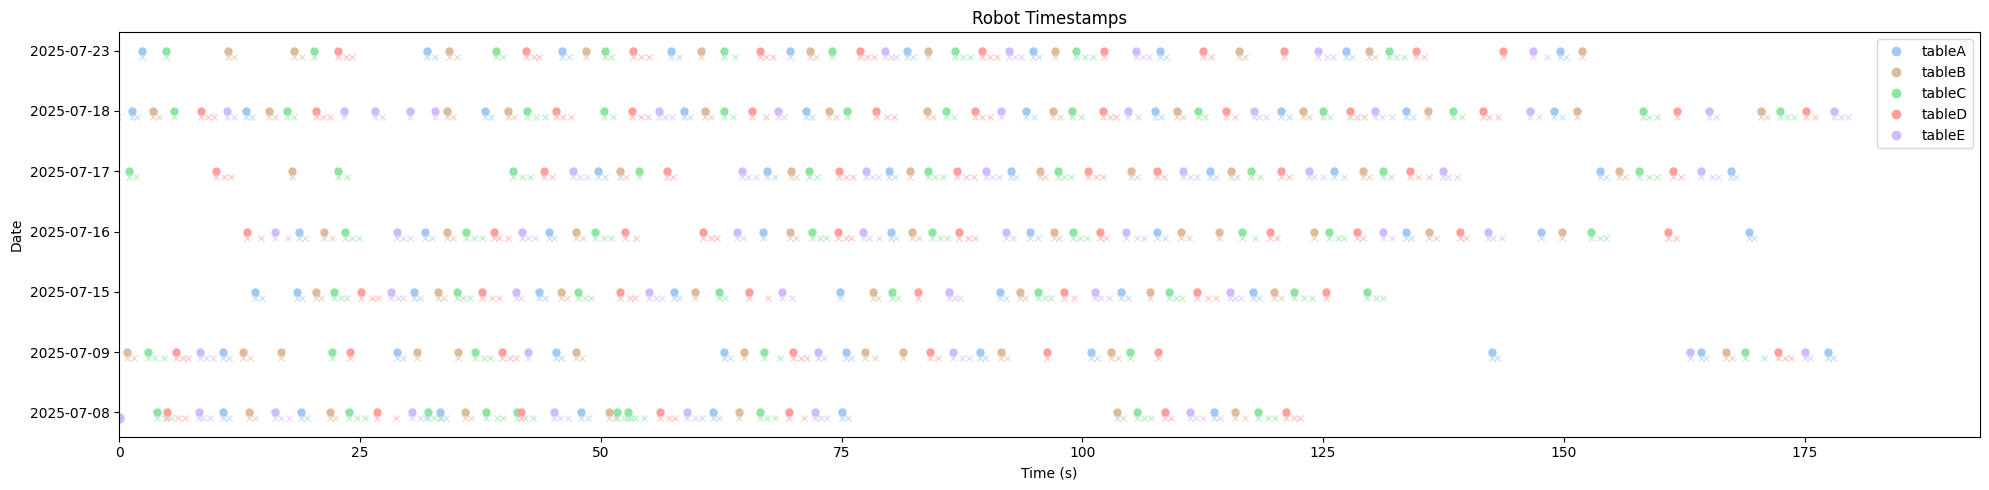

In [6]:
labels = []

fig, ax = plt.subplots(figsize=(20, 5))

for idx, day in enumerate(robot_timestamps):
    for table in robot_timestamps[day]:
        for timestamp in robot_timestamps[day][table]:
            plt.plot((timestamp/60), idx, 'o', color=colors_table[table], markersize=5)
            for subtimestamp in robot_timestamps[day][table][timestamp]:
                plt.plot((subtimestamp/60), idx-0.1, 'x', color=colors_table[table], markersize=5, alpha=0.5)

for table, color in colors_table.items():
    plt.plot(0,-0.1, 'o', color=color, label=table)
plt.legend()

plt.xlabel("Time (s)")
plt.ylabel("Date")
ax.set_xlim(0, ax.get_xlim()[1])
plt.title("Robot Timestamps")
ax.set_yticks(list(range(len(robot_timestamps))))
ax.set_yticklabels(list(robot_timestamps.keys()))
fig.tight_layout()
plt.show()

In [7]:
data_egocentric = {date: {table_name: {timestamp: [] for timestamp in robot_timestamps[date][table_name]} for table_name in robot_timestamps[date]} for date in robot_timestamps}

def aggregate_scenegraphs(scenegraphs):
    scene_graph_combined = scenegraphs[0]
    for scenegraph_this in scenegraphs[1:]:
        new_objects = Counter(scenegraph_this) - Counter(scene_graph_combined)
        for object, count in new_objects.items():
            if count > 0:
                scene_graph_combined += [object] * count
    return scene_graph_combined

for date in data_egocentric:
    for table_name in data_egocentric[date]:
        for timestamp in data_egocentric[date][table_name]:
            subscenegraphs = []
            if len(data[date][table_name]) == 0:
                VERBOSE and print(f"No data for {date} {table_name}")
                data_egocentric[date][table_name] = {}
                continue
            VERBOSE and print(f"Looking for {robot_timestamps[date][table_name][timestamp]}")
            for subtimestamp in robot_timestamps[date][table_name][timestamp]:
                closest_timestamp_in_data = min(data[date][table_name].keys(), key=lambda x: abs(x - subtimestamp))
                VERBOSE and print(f"Found {closest_timestamp_in_data}", end=", ")
                subscenegraphs.append(data[date][table_name][closest_timestamp_in_data])
            VERBOSE and print()
            if len(subscenegraphs) == 0:
                VERBOSE and print(f"No observations found for {date} {table_name}")
                data_egocentric[date][table_name] = {}
            else:
                data_egocentric[date][table_name][timestamp] = aggregate_scenegraphs(subscenegraphs)


json.dump(data_egocentric, open(data_filename_processed.replace("GT", "ego"), "w"), indent=4)

### !!! Override using all graphs !!!

In [8]:
# data_egocentric = data
# flog("USING OVERHEAD DATA WITHOUT ROBOT FILTERING!!!!")

Median timestamp difference: 13.041666666666666 minutes


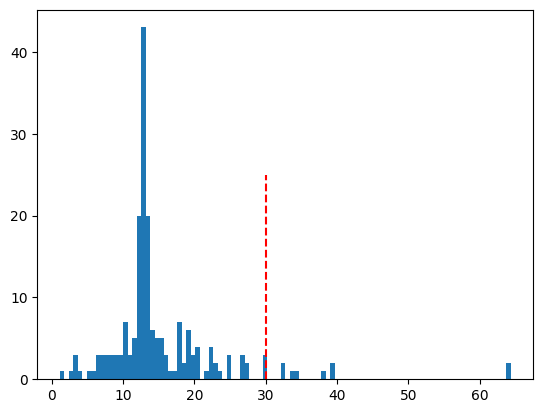

In [9]:
## Find median difference between timestamps over all tables and dates
timestamp_diffs = []
for date in data_egocentric:
    for table_name in data_egocentric[date]:
        timestamps = list(data_egocentric[date][table_name].keys())
        timestamps.sort()
        timestamp_diffs.extend(np.diff(timestamps))

thresh = 60*30
print(f"Median timestamp difference: {np.median([t for t in timestamp_diffs if t<thresh])/60} minutes")
plt.hist(np.array(timestamp_diffs)/60, bins=100)
plt.plot([thresh/60, thresh/60], [0, 25], 'r--')
plt.show()

## Generate graph sequences in SLaTe-PRO format with constant timestep

In [10]:
import torch

In [11]:
objects_masterlist = open("../../object_list.txt", "r").read().splitlines()
tables = [o for o in objects_masterlist if o.startswith("table")]
supplyshelf = [o for o in objects_masterlist if o.startswith("supply")]
if NO_SUPPLYSHELF: 
    supplyshelf = []
    objects_masterlist.remove("supplyshelf")

surfaces = tables + supplyshelf
room = [o for o in objects_masterlist if o.startswith("room")]
objects = [o for o in objects_masterlist if o not in tables and o not in supplyshelf and o not in room]

print("Objects Masterlist:", ', '.join(objects_masterlist))
print("Tables:", ', '.join(tables))
print("Supply Shelves:", ', '.join(supplyshelf))
print("Rooms:", ', '.join(room))
print("Objects:", ', '.join(objects))
print("Surfaces:", ', '.join(surfaces))

static_graph_edges = torch.zeros(len(objects_masterlist), len(objects_masterlist), dtype=torch.float32)
active_edges_mask = torch.zeros_like(static_graph_edges, dtype=torch.float32)
for surface in surfaces:
    static_graph_edges[objects_masterlist.index(surface), objects_masterlist.index("room")] = 1.0
    for object in objects:
        active_edges_mask[objects_masterlist.index(object), objects_masterlist.index(surface)] = 1.0


Objects Masterlist: room, tableA, tableB, tableC, tableD, tableE, coasters, cup, etchpen, flower, foamball, gemset, glue, googlyeyes, keychain, moss, mossframe, paint, paintbrush, palette, photoframe, plantpot, stones, suncatcher, tissuebox, varnish
Tables: tableA, tableB, tableC, tableD, tableE
Supply Shelves: 
Rooms: room
Objects: coasters, cup, etchpen, flower, foamball, gemset, glue, googlyeyes, keychain, moss, mossframe, paint, paintbrush, palette, photoframe, plantpot, stones, suncatcher, tissuebox, varnish
Surfaces: tableA, tableB, tableC, tableD, tableE


In [12]:
dt = 10.0
print("Using dt: ", dt)

common_data = {
    'dt': dt,
    'start_time': 0.0,
    'end_time': 60*3,
    'node_classes': objects_masterlist,
    'node_categories': ['Rooms' if obj in room else 'Furniture' if obj in surfaces else 'placable_objects' for obj in objects_masterlist],
    'edge_keys': ["ON"],
    'static_nodes': [obj for obj in objects_masterlist if obj not in objects],
    'static_node_categories': ["Rooms", "Furniture"],
    'dataset_type': "RoboCraft",
    'n_stations': 5,
    'stations': ['tableA', 'tableB', 'tableC', 'tableD', 'tableE'],
    'dates': list(data_egocentric.keys()),
    'active_edge_ranges': 
        [[int(np.where(active_edges_mask)[1].min()), int(np.where(active_edges_mask)[1].max())],
         [int(np.where(active_edges_mask)[0].min()), int(np.where(active_edges_mask)[0].max())]]
}
json.dump(common_data, open("processed_seqLM_coarse/common_data.json", "w"), indent=4)

common_edge_data = {}
common_edge_data['home_graph'] = static_graph_edges.clone()
for obj in objects:
    common_edge_data['home_graph'][objects_masterlist.index(obj), objects_masterlist.index('room')] = 1.0
common_edge_data['nonstatic_edges'] = active_edges_mask.clone()
common_edge_data['seen_edges'] = torch.zeros_like(active_edges_mask, dtype=torch.float32)
torch.save(common_edge_data, "processed_seqLM_coarse/common_edge_data.pt")

common_embedding_map = {}


Using dt:  10.0


In [13]:
def convert_to_slatepro_format(sg_egocentric):
    ## sg_egocentric is a dictionary of table_name -> list of objects
    sg_slatepro = torch.zeros(len(objects_masterlist), len(objects_masterlist), dtype=torch.float32)
    persons_per_table = torch.zeros((common_data['n_stations']), dtype=torch.float32)
    for table_name, objects in sg_egocentric.items():
        for object in objects:
            if object == "person":
                persons_per_table[common_data['stations'].index(table_name)] += 1
            else:
                sg_slatepro[objects_masterlist.index(object), objects_masterlist.index(table_name)] = 1.0
    if not NO_SUPPLYSHELF:
        for object in objects:
            sg_slatepro[objects_masterlist.index(object), objects_masterlist.index(supplyshelf[0])] = 1.0
        
    return sg_slatepro, persons_per_table


In [14]:
average_num_movements = []
average_prob_of_movement = []
for date, data_egocentric_this_date in data_egocentric.items():
    VERBOSE and print(f"\n\nProcessing {date}")
    nodes = torch.tensor([i for i in range(len(objects_masterlist))], dtype=torch.float32)
    times = torch.arange(common_data['start_time']-common_data['dt'], common_data['end_time'], common_data['dt'], dtype=torch.float32)
    scene_graph_list = []
    activity_list = []
    fig, ax = plt.subplots(1, len(times))
    ax = ax.flatten()
    number_of_movements = 0
    number_of_possible_movements = 0
    ax[0].set_yticks(np.arange(0, len(objects_masterlist)), labels=objects_masterlist, fontsize=10)
    for idx, timestamp_slatepro in enumerate(times):
        sg_egocentric = {}
        VERBOSE and print(f"Timestamp: {timestamp_slatepro*60}")
        for table_name in common_data['stations']:
            if len(data_egocentric_this_date[table_name]) == 0:
                VERBOSE and print(f"{table_name}: No data")
                sg_egocentric[table_name] = []
                continue
            most_recent_timestamp = min(data_egocentric_this_date[table_name].keys(), key=lambda x: (abs(x - timestamp_slatepro*60) if (timestamp_slatepro*60 >= x) else float('inf')))
            if most_recent_timestamp > timestamp_slatepro*60:
                VERBOSE and print(f"{table_name}: No timestamp found")
                sg_egocentric[table_name] = []
            else:
                VERBOSE and print(f"{table_name}: Found {most_recent_timestamp/60}")
                sg_egocentric[table_name] = data_egocentric_this_date[table_name][most_recent_timestamp]
        sg, per = convert_to_slatepro_format(sg_egocentric)
        if len(scene_graph_list) > 0:
            sg_viz = sg.clone()-scene_graph_list[-1]
            number_of_movements += sg_viz.sum().abs()
            number_of_possible_movements += torch.numel(sg_viz[active_edges_mask.to(bool)])
            VERBOSE and print(f"Number of movements: {number_of_movements}", end="\r")
        else:
            sg_viz = sg.clone()
        sg_viz[sg_viz > 0] = 1
        sg_viz[0,0] = 1
        ax[idx].imshow(sg_viz, cmap='viridis', vmin=-1, vmax=1)
        # ax[idx].imshow(active_edges_mask, cmap='gray', alpha=0.3)
        ax[idx].set_title(f"{int(timestamp_slatepro)} mins")
        scene_graph_list.append(sg)
        activity_list.append(per)
        if len(scene_graph_list) == 1:
            scene_graph_list.append(sg)
            activity_list.append(per)
        ax[idx].set_xticks(np.arange(0, len(objects_masterlist)), labels=objects_masterlist, fontsize=10, rotation=90)
        ax[idx].set_xlim(np.where(active_edges_mask)[1].min(), np.where(active_edges_mask)[1].max())
        ax[idx].set_ylim(np.where(active_edges_mask)[0].min(), np.where(active_edges_mask)[0].max())
    average_num_movements.append(number_of_movements)
    average_prob_of_movement.append(number_of_movements/number_of_possible_movements)
    flog(f"Number of movements recorded for {date}: {number_of_movements}")
    flog(f"Probability of object movement: {number_of_movements/number_of_possible_movements} ({number_of_movements}/{number_of_possible_movements})")

    fig.suptitle(date)
    fig.set_size_inches(1.5*len(times), 5)
    fig.tight_layout()
    plt.savefig(f"processed_seqLM_coarse/figures/{date}.png")
    plt.close()
    
    times = torch.cat([times[:1]-common_data['dt'], times])
    # times = torch.cat([times[:1]-common_data['dt'], times, times[-1:]+common_data['dt']])
    scene_graph_list = [scene_graph_list[0]]+scene_graph_list
    activity_list = [activity_list[0]]+activity_list
    
    torch.save({
            'nodes': nodes,
            'edges': torch.stack(scene_graph_list, dim=0),
            'times': times,
            'active_edges': active_edges_mask,
            'activity': torch.stack(activity_list, dim=0),
        }, f"processed_seqLM_coarse/all/{date}.pt")

    print(f"Written to processed_seqLM_coarse/all/{date}.pt")
    
flog(f"Average number of movements: {sum(average_num_movements)/len(average_num_movements)}")
flog(f"Average probability of object movement: {sum(average_prob_of_movement)/len(average_prob_of_movement)}")

p = sum(average_prob_of_movement)/len(average_prob_of_movement)
flog(f"Random model performance: \n\tTP={p*p}, \n\tFP/TN={p*(1-p)}, \n\tFN={(1-p)*(1-p)}, \n\tPrecision={p*p/(p*p+(1-p)*p)}, \n\tRecall={p*p/(p*p+(1-p)*p)}")

Number of movements recorded for 2025-07-08: 11.0
Probability of object movement: 0.0061111110262572765 (11.0/1800)
Written to processed_seqLM_coarse/all/2025-07-08.pt
Number of movements recorded for 2025-07-09: 25.0
Probability of object movement: 0.013888888992369175 (25.0/1800)
Written to processed_seqLM_coarse/all/2025-07-09.pt
Number of movements recorded for 2025-07-15: 18.0
Probability of object movement: 0.009999999776482582 (18.0/1800)
Written to processed_seqLM_coarse/all/2025-07-15.pt
Number of movements recorded for 2025-07-16: 14.0
Probability of object movement: 0.007777777966111898 (14.0/1800)
Written to processed_seqLM_coarse/all/2025-07-16.pt
Number of movements recorded for 2025-07-17: 45.0
Probability of object movement: 0.02500000037252903 (45.0/1800)
Written to processed_seqLM_coarse/all/2025-07-17.pt
Number of movements recorded for 2025-07-18: 38.0
Probability of object movement: 0.021111110225319862 (38.0/1800)
Written to processed_seqLM_coarse/all/2025-07-18.p

## Temporary patches to test

In [15]:
shutil.copytree("processed_seqLM_coarse/all", "processed_seqLM_coarse/train")
shutil.copytree("processed_seqLM_coarse/all", "processed_seqLM_coarse/test")


'processed_seqLM_coarse/test'